# Structural Analysis Toolkit (SAT)

## If anything goes wrong:  
### Restart the kernel using the &#8635; button at the top of this notebook, or from the menu: `Kernel > Restart Kernel...`

## **During the tutorials just run through the cells using the given example files and code. Later you will use your own CAD drawing and edit the code to solve your own structural optimisation problem.**

## Loading the external files

### 0. Upload your DXF file (the example used here is called `example.dxf`), to the file browser on the left.
### 1. Run the cell below to load it into Python and create lists of `Node` and `Member` objects.

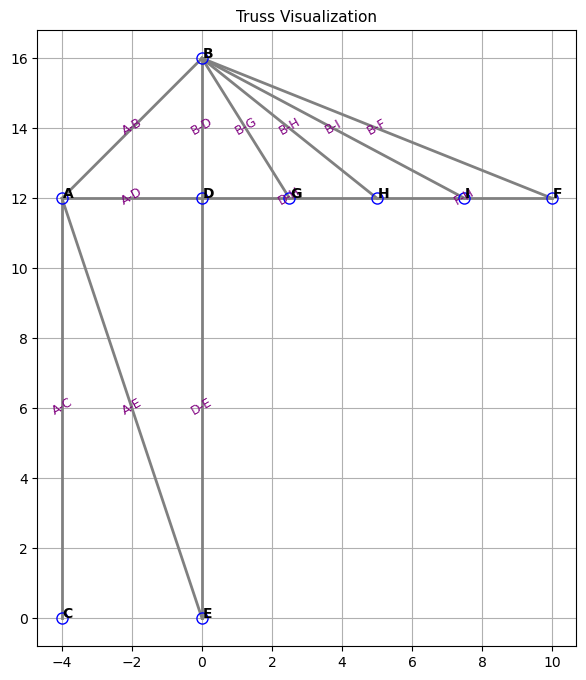

In [1]:
# ===================================================
# Ensure the input filenames below match uploded files
# ===================================================
from import_functions import extract_structure_from_dxf

# input files
INPUT_DXF = "cover.dxf"

# import data and create lists of nodes and members, each with its own ID, name, properties, etc...
nodes, members = extract_structure_from_dxf(INPUT_DXF, units='mm', tol=0.1)

##########################################
# Visualisation of the imported structure
##########################################
import visualisation_functions as viz

# show the imported structure
viz.visualize_truss(nodes, members, textscale=1, show_node_labels=True, show_member_labels=True)

#### &bullet; **Make sure all of the members and joints have unique labels,**
#####      $-$ if not you need to edit your CAD drawing to make it more accurate.

* We can inspect the nodes (and members) created:

In [2]:
# list the nodes
print(nodes)

{'A': <structural_classes.Node object at 0x75033a1c7010>, 'B': <structural_classes.Node object at 0x75033a1c6f10>, 'C': <structural_classes.Node object at 0x75033a1c6f90>, 'D': <structural_classes.Node object at 0x75033a1c6e90>, 'E': <structural_classes.Node object at 0x75033a1c6a10>, 'F': <structural_classes.Node object at 0x75033a1c6690>, 'G': <structural_classes.Node object at 0x75033a1c6590>, 'H': <structural_classes.Node object at 0x75033a1c6390>, 'I': <structural_classes.Node object at 0x75033a1c5fd0>}


This is a dictionary with each of the nodes listed, lets look at one:
* click immediately after `.` and press the tab key to view attributes (properties) of the node object
* click on any of them (or type it) to view that property
e.g.:
```python
node.F_x
```

In [3]:
node = nodes['C']
node.F_x

0.0

### 2. Edit the dictionary in the cell below then run it to assign different joint types:

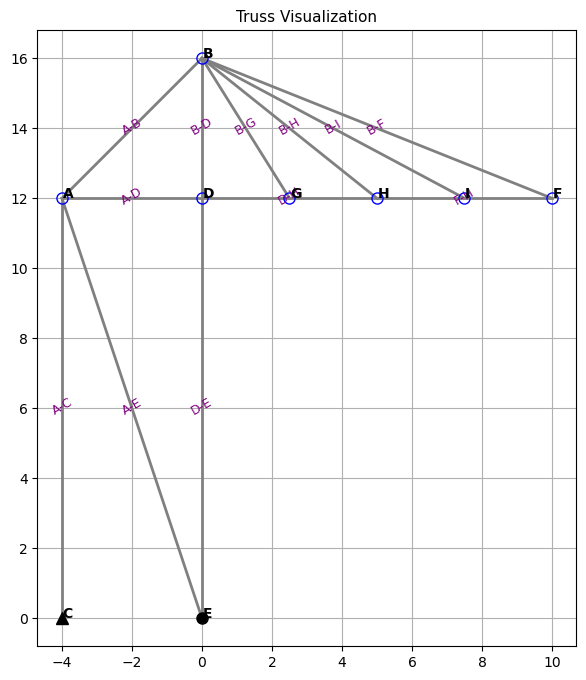

In [4]:
##########################################
# Edit this to assign conditions to joints
##########################################

# comma-separated lists of node-labels as dictionary values 
# default value is "Pinned"
JOINT_CONDITIONS = {
"Pinned":            [],	 # Internal pin (free rotation, no support)	    ○	Blue
"Fixed":             [],     # Internal fixed joint (rigid)	                □	Blue
"Reaction_Fixed":    [],	 # External fixed support	                    ■	Black
"Reaction_Pinned":   ['E'],	 # External pinned support	                    ●	Black
"Reaction_Roller_H": ['C'],  # Horizontal roller (restrained vertically)	▲	Black
"Reaction_Roller_V": []	     # Vertical roller (restrained horizontally)	▼	Black
}

#########################
# Assign point conditions 
#########################
from struct_prop_funcs import apply_joint_conditions

# assign joint conditions
apply_joint_conditions(nodes, JOINT_CONDITIONS)

viz.visualize_truss(nodes, members, textscale=1, show_node_labels=True, show_member_labels=True)

| Type                | Description                               | Marker | Colour |
| ------------------- | ----------------------------------------- | ------ | ----- |
| `Pinned`            | Internal pin (free rotation, no support)  | ○      | Blue  |
| `Fixed`             | Internal fixed joint (rigid)              | □      | Blue  |
| `Reaction_Fixed`    | External fixed support                    | ■      | Black |
| `Reaction_Pinned`   | External pinned support                   | ●      | Black |
| `Reaction_Roller_H` | Horizontal roller (restrained vertically) | ▲      | Black |
| `Reaction_Roller_V` | Vertical roller (restrained horizontally) | ▼      | Black |

### 3. Import the Materials list and properties from the `materials.xlsx` Excel file
* To edit your own: Download the `materials.xlsx` file (right-click in the file browser on the left) edit and re-upload (drag and drop into the file-browser or use the up arrow &uarr; above the file list). **Do not change the basic formatting of the excel sheet**, only add new rows or properties columns if needed.
### Run the cell below to import the file and display its contents


In [5]:
from import_functions import read_materials_from_excel

MATERIAL_EXCEL = "materials.xlsx"  # path to your file

# import materials -> dataframe keyed by material name
material_props_df = read_materials_from_excel(MATERIAL_EXCEL, print_contents=False)
material_props_df

Material,114.3 x 10 CHS - S355,254x343x63 - T - S355
E,210.00,210.00
Density,7850.00,7850.00
fc,355.00,355.00
ft,355.00,355.00
A,3.94,79.70
I_xx,450.00,2190.00
I_yy,450.00,8980.00
y_xx,57.15,8.85
y_yy,10.00,3.00


### 4.  Manual Configuration of Properties for `members`

### Edit the dictionaries in the cell below then run it to assign different joint and material properties:

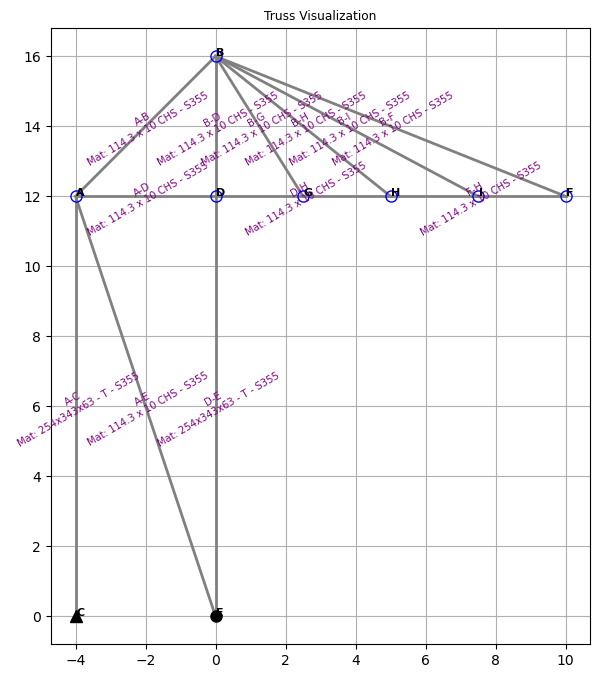

    Assigned Member Material Properties
 ---------------------------------------
                     Material      E     fc     ft Density      A    I_xx  \
Member                                                                      
D-E     254x343x63 - T - S355  210.0  355.0  355.0  7850.0  79.70  2190.0   
B-D     114.3 x 10 CHS - S355  210.0  355.0  355.0  7850.0   3.94   450.0   
B-F     114.3 x 10 CHS - S355  210.0  355.0  355.0  7850.0   3.94   450.0   
A-D     114.3 x 10 CHS - S355  210.0  355.0  355.0  7850.0   3.94   450.0   
A-E     114.3 x 10 CHS - S355  210.0  355.0  355.0  7850.0   3.94   450.0   
A-C     254x343x63 - T - S355  210.0  355.0  355.0  7850.0  79.70  2190.0   
A-B     114.3 x 10 CHS - S355  210.0  355.0  355.0  7850.0   3.94   450.0   
B-H     114.3 x 10 CHS - S355  210.0  355.0  355.0  7850.0   3.94   450.0   
D-H     114.3 x 10 CHS - S355  210.0  355.0  355.0  7850.0   3.94   450.0   
F-H     114.3 x 10 CHS - S355  210.0  355.0  355.0  7850.0   3.94   450.

In [6]:
##########################################
# Edit this to assign materials to members 
#  * Note: names are very sensitive to number of spaces and upper/lower-case letters
##########################################

MANUAL_MATERIALS = {
"114.3 x 10 CHS - S355": ["A-B", "B-D"],
"254x343x63 - T - S355": ["A-C", "D-E"],
}

# any unassigned materials will get this one:
DEFAULT_MATERIAL = "114.3 x 10 CHS - S355"


##################
# Assign materials 
##################
from struct_prop_funcs import assign_materials_to_members
from printing_tools import member_dataframe


# assign materials: only names that exist in Excel will be assigned; others -> None
assign_materials_to_members(members, MANUAL_MATERIALS, material_props_df, default_material=DEFAULT_MATERIAL)

# Plot a figure of the new truss system
viz.visualize_truss(nodes, members, show_node_labels=True, show_member_labels=True, show_material_labels=True, textscale=0.8)

# show table and export
df = member_dataframe(members)

MEMBER_PROPERTY_FILE = "member_properties.xlsx"
# save member properties to excel
df.to_excel(MEMBER_PROPERTY_FILE)

## Next follows some examples of what you can do with your structural objects...

### 5. Check if Determinate

#### 2D truss diagnostics with automatic connectivity and total unknown reaction check.

Prints a detailed report including:
- Determinacy check
- Support reaction analysis
- Potential mechanism nodes
- Total unknown reaction check

In [7]:
n_nodes = len(nodes)
n_members = len(members)
n_reactions = sum(n.unknowns for n in nodes.values())
determinant = 2 * n_nodes - (n_members + n_reactions)

print("\n=== Truss Diagnostics ===")
print(f"Number of nodes (joints):       {n_nodes}")
print(f"Number of members:             {n_members}")
print(f"Number of unknown reactions:   {n_reactions}")
print(f"Determinant (2j - (m+r)):     {determinant}")
# --- Overall determinacy status (truss) ---
if determinant == 0:
    status = "=> Statically determinate (truss)"
elif determinant > 0:
    status = "!!! Unstable mechanism possible (truss)"
else:
    status = "!!! Statically indeterminate (truss)"
print(f"Status: {status}\n")

# --- Support analysis ---
print("Supports and unknown reaction components:")
problem_supports = []
for label, n in nodes.items():
    cond = n.condition
    if "Reaction" in cond: 
        unknowns = n.unknowns
        print(f"  Node {label:>3}: {cond:20} -> {unknowns} unknown reaction(s)")
        if unknowns > 2:
            problem_supports.append((label, cond, "Too many unknown reactions → may cause indeterminacy"))

if problem_supports:
    print("\nProblematic Supports:")
    for label, cond, issue in problem_supports:
        print(f"  Node {label:>3}: {cond:20} -> {issue}")
else:
    print("\nNo problematic supports detected.")

# Total unknown reaction check for rigid 2D body
print("\nTotal unknown reaction check:")
if n_reactions > 3:
    print(f"!!! Total unknown reactions = {n_reactions} > 3 --> system is statically indeterminate for rigid 2D body")
elif n_reactions < 3:
    print(f"!!! Total unknown reactions = {n_reactions} < 3 --> system may be unstable (mechanism possible)")
else:
    print(f"=> Total unknown reactions = {n_reactions} --> statically determinate for rigid 2D body")

# Potential mechanism nodes
potential_mech_nodes = []
for label, n in nodes.items():
    cond = n.condition
    if "Reaction" in cond:
        continue  # skip supports
    n_conn = len(n.connectivity) #number of members from the node
    if n_conn < 2:
        potential_mech_nodes.append((label, n_conn, "Too few connected members --> possible local mechanism"))

if potential_mech_nodes:
    print("\nPotential Mechanism Nodes:")
    for label, n_conn, issue in potential_mech_nodes:
        print(f"  Node {label}: {n_conn} member(s) connected -> {issue}")
else:
    print("\nNo obvious local mechanism nodes detected.")




=== Truss Diagnostics ===
Number of nodes (joints):       9
Number of members:             12
Number of unknown reactions:   3
Determinant (2j - (m+r)):     3
Status: !!! Unstable mechanism possible (truss)

Supports and unknown reaction components:
  Node   C: Reaction_Roller_H    -> 1 unknown reaction(s)
  Node   E: Reaction_Pinned      -> 2 unknown reaction(s)

No problematic supports detected.

Total unknown reaction check:
=> Total unknown reactions = 3 --> statically determinate for rigid 2D body

Potential Mechanism Nodes:
  Node G: 1 member(s) connected -> Too few connected members --> possible local mechanism
  Node I: 1 member(s) connected -> Too few connected members --> possible local mechanism


## Do Structural Calculations

### 6. Define the loads and run the cell below to perform load calculations

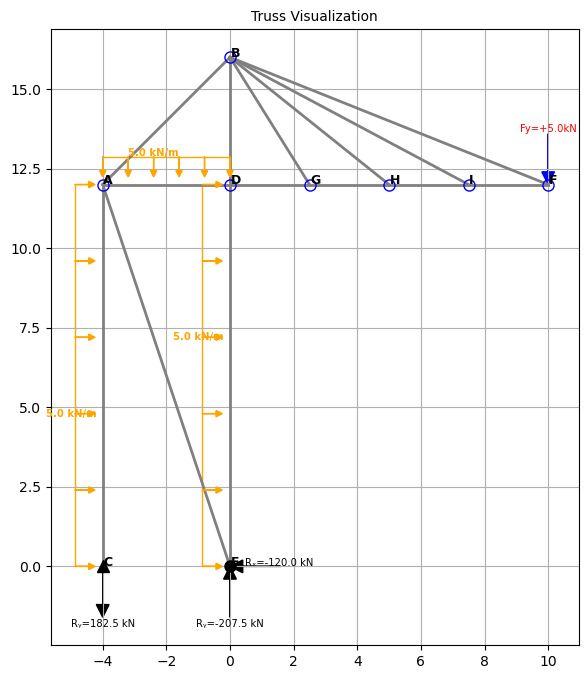

In [8]:
# ==========================
#   LOAD ASSIGNMENT
# ==========================

# Point load configuration
nodes['F'].F_y = 5.0 # F_x is already zero

# member loads
members['D-E'].F_x = 5.0 # 5 kN/m right UDL on member DE
members['A-C'].F_x = 5.0 # 5 kN/m right UDL on member AC
members['A-D'].F_y = 5.0 # 5 kN/m down UDL on member AD


# ==============================
# PERFORM LOAD CALCULATIONS HERE
# ==============================
from struct_prop_funcs import calculate_total_forces
from structural_analysis import compute_support_reactions


# Apply loads
calculate_total_forces(nodes, members) 

reactions = compute_support_reactions(nodes, verbose=False)

# Visualize
viz.visualize_truss(nodes, members, textscale=0.9, reactions=reactions, plot_loads=True, show_load_labels=True, show_member_labels=False, show_node_labels=True,  show_force_labels=True)

### 7. Check Equilbrium

In [9]:
# Step 6: Detailed moment equilibrium check (debug)
print("\n--- Moment Equilibrium Breakdown (Clockwise Positive) ---")
print(f"{'Label':<8} {'x':>8} {'y':>8} {'Fx':>10} {'Fy':>10} {'M = (xFy + yFx)':>18}")

# Applied loads (clockwise positive)
for lbl, n in nodes.items():
    Fx = n.F_xtotal or n.F_x #uses F_xtotal if it is non-zero, F_x otherwise
    Fy = n.F_ytotal or n.F_y
    x, y = n.coords[:2]
    M = (x * Fy + y * Fx)  # negative for clockwise positive
    print(f"{lbl:<8} {x:8.3f} {y:8.3f} {Fx:10.3f} {Fy:10.3f} {M:18.6f}")

# Supports and reactions
support_labels = [lbl for lbl in reactions.keys()]
support_nodes = {lbl: nodes[lbl] for lbl in support_labels}

print("---- Reactions (Clockwise Positive) ----")
for lbl, r in reactions.items():
    s = support_nodes[lbl]
    x, y = s.coords[:2]
    M = (x * r['Ry'] + y * r['Rx'])  # clockwise positive
    print(f"{lbl:<8} {x:8.3f} {y:8.3f} {r['Rx']:10.3f} {r['Ry']:10.3f} {M:18.6f}")

# Compute totals (clockwise positive)
M_total_loads = sum(
    n.coords[0] * (n.F_ytotal or n.F_y)
    + n.coords[1] * (n.F_xtotal or n.F_x)
    for n in nodes.values()
)
M_total_reac = sum(
    support_nodes[l].coords[0] * r['Ry']
    + support_nodes[l].coords[1] * r['Rx']
    for l, r in reactions.items()
)
M_check = M_total_loads + M_total_reac

print(f"\nM_total (loads, CW+) = {M_total_loads:.6f}")
print(f"M_reactions (CW+)   = {M_total_reac:.6f}")
print(f"ΣM (CW+) = {M_check:.6e}  (should be ≈ 0)\n")




--- Moment Equilibrium Breakdown (Clockwise Positive) ---
Label           x        y         Fx         Fy    M = (xFy + yFx)
A          -4.000   12.000     30.000     10.000         320.000000
B           0.000   16.000      0.000      0.000           0.000000
C          -4.000    0.000     30.000      0.000           0.000000
D           0.000   12.000     30.000     10.000         360.000000
E           0.000    0.000     30.000      0.000           0.000000
F          10.000   12.000      0.000      5.000          50.000000
G           2.500   12.000      0.000      0.000           0.000000
H           5.000   12.000      0.000      0.000           0.000000
I           7.500   12.000      0.000      0.000           0.000000
---- Reactions (Clockwise Positive) ----
C          -4.000    0.000      0.000    182.500        -730.000000
E           0.000    0.000   -120.000   -207.500          -0.000000

M_total (loads, CW+) = 730.000000
M_reactions (CW+)   = -730.000000
ΣM (CW+) = -3.4

### 8. Use method X to solve Y

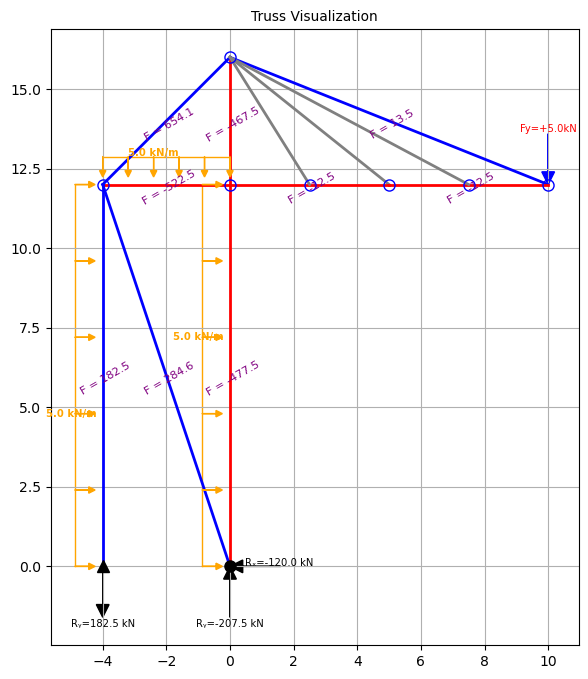

In [10]:
from structural_analysis import solve_truss_joint_iteration


# STRUCTURAL ANALYSIS
member_forces = solve_truss_joint_iteration(nodes, members)

# Visualize everything
viz.visualize_truss(nodes, members, textscale=0.9, reactions=reactions, plot_loads=True, forces=member_forces, show_load_labels=True, show_forces=True, show_member_labels=False,  show_force_labels=True)

### 9. Compute and visualise member bending moments

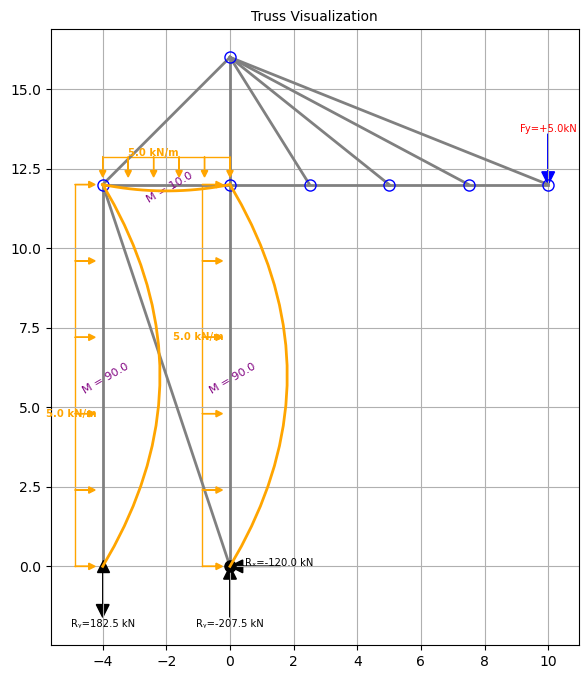

In [11]:
from structural_analysis import compute_member_bending_moments

member_moments = compute_member_bending_moments(members)

viz.visualize_truss(nodes, members, textscale=0.9, reactions=reactions, plot_loads=True, moments=member_moments, show_forces=False,show_load_labels=True, show_moments=True, show_moment_labels=True, moment_scale=0.02)

## Next Steps... Do interesting things!

### 10. Calculates Stresses:

We need to account for the plus/minus effect:

σ total= σ axial ± σ bending

Tension axial stress + bending at the top fiber
Compression axial stress + bending at the top fiber

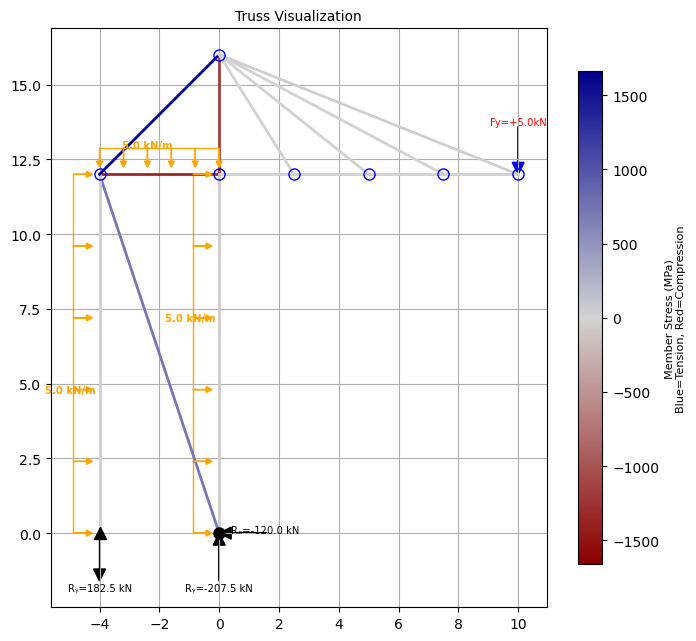

In [12]:
### Compute combined stresses (axial + bending) for all members.
### =======
### MODEL ANSWER???
### ==========
import numpy as np 

stresses = {}
max_stress = 0.0

for m in members.values():
    if m.rotation==0:
        props = m.properties
        A = props['A'] 
        I = props['I_xx'] 
        y = props['y_xx']
    else: 
        props = m.properties
        A = props['A'] 
        I = props['I_yy'] 
        y = props['y_yy']

    # Axial stress
    F = m.force ### CHECK UNITS ###
    sigma_axial = (1000*F) / ( A * 100)  # tension positive #N/mm^2

    # Bending stress
    sigma_bending_curve = 0.0
    sigma_bending_max = 0.0
    sigma_bending_min = 0.0

    moment = m.moment
    if moment:
        M_curve = moment["points"]
        if len(M_curve) > 0:
            sigma_bending_curve = np.array(M_curve) * y / I
            sigma_bending_max = np.max(sigma_bending_curve)
            sigma_bending_min = np.min(sigma_bending_curve)

    # Combined total stress (select most critical)
    sigma_total_pos = sigma_axial + sigma_bending_max
    sigma_total_neg = sigma_axial + sigma_bending_min
    sigma_total = sigma_total_pos if abs(sigma_total_pos) >= abs(sigma_total_neg) else sigma_total_neg

    stresses[m.name] = sigma_total
    max_stress = max(max_stress, abs(sigma_total))



viz.visualize_truss(nodes, members, textscale=0.9, reactions=reactions, plot_loads=True, show_load_labels=True, stresses=stresses, show_stresses=True, show_colorbar=True )


### 11. Compute utilisation factors for members based on stress and material properties.


=== Utilisation Summary ===
Member       σ_total (MPa)     Allow (MPa)         Type     Utilisation
---------------------------------------------------------------------------
D-E                -59.912         355.000  Compression           0.169
B-D              -1186.548         355.000  Compression           3.342
B-F                 34.170         355.000      Tension           0.096
A-D              -1326.142         355.000  Compression           3.736
A-E                722.348         355.000      Tension           2.035
A-C                 22.898         355.000      Tension           0.065
A-B               1660.086         355.000      Tension           4.676
B-H                  0.000         355.000      Tension           0.000
D-H                -31.726         355.000  Compression           0.089
F-H                -31.726         355.000  Compression           0.089
B-I                  0.000         355.000      Tension           0.000
B-G                  0.000     

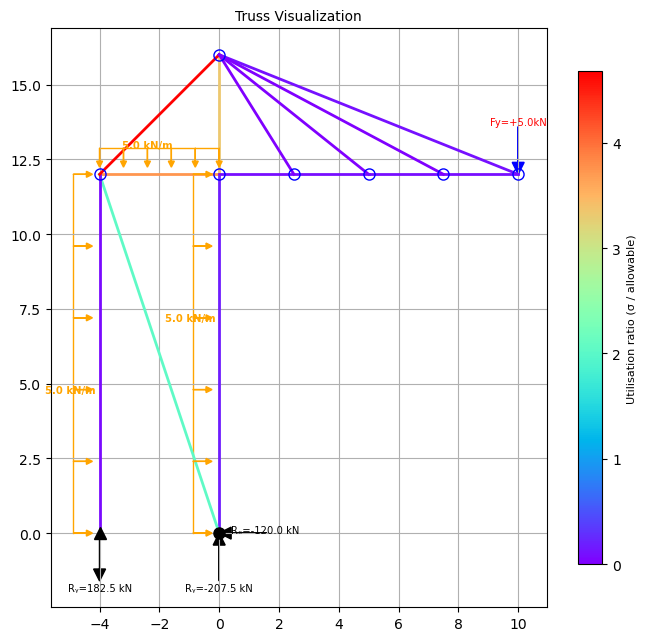

In [13]:
import math

warn_limit=1.0
utilisations = {}
max_utilisation = 0.0
overstressed = []

# ANSI color helpers
RED = "\033[91m"
RESET = "\033[0m"

print("\n=== Utilisation Summary ===")
print(f"{'Member':<10} {'σ_total (MPa)':>15} {'Allow (MPa)':>15} {'Type':>12} {'Utilisation':>15}")
print("-" * 75)

for m in members.values():
    sigma = stresses[m.name] 
    props = m.properties

    ft = props["ft"] 
    fc = props["fc"] 

    # Decide allowable stress based on sign
    if sigma >= 0:
        allowable = ft 
        stress_type = "Tension"
    else:
        allowable = fc 
        stress_type = "Compression"

    util = abs(sigma) / allowable

    utilisations[m.name] = util
    if not math.isinf(util):
        max_utilisation = max(max_utilisation, util)

    # Highlight overstressed members
    over = util > warn_limit
    allow_str = f"{allowable:.3f}" 
    util_str = f"{util:.3f}" 

    line = f"{m.name:<10} {sigma:15.3f} {allow_str:>15} {stress_type:>12} {util_str:>15}"
    if over:
        line = RED + line + RESET
        overstressed.append((m.name, util))

    print(line)

print("-" * 75)
print(f"Max utilisation = {max_utilisation:.3f}")

if overstressed:
    print(f"\n!!!  Overstressed members (util > {warn_limit}):")
    for name, util in overstressed:
        print(f"  - {name}: {util:.3f}")
else:
    print("\n=> All members within allowable limits.")




viz.visualize_truss(nodes, members, textscale=0.9, reactions=reactions, plot_loads=True, show_load_labels=True, utilisations=utilisations, show_utilisations=True, show_colorbar=True )


## Making modifications to the structure

### 12. Run this to see and example of a structural change:

In [14]:
from computation_tools import compute_member_lengths, compute_node_angles
from printing_tools import comparison_data

# Factor to stretch the structure vertically
WIDTH_SCALE = 2.5

# Store original angles and lengths
original_lengths = compute_member_lengths(members)
original_angles = compute_node_angles(nodes, members)

# scale and visualize
for n in nodes.values():
    n.coords[0]*=WIDTH_SCALE

# calculate new angles and lengths
new_lengths = compute_member_lengths(members)
new_angles = compute_node_angles(nodes, members)

# Show the values as a table
df = comparison_data(original_angles, new_angles, original_lengths, new_lengths, print_output=False)

COMPARISON_SHEET_FILENAME = "compare_angles.xlsx"

# save data to excel
df.to_excel(COMPARISON_SHEET_FILENAME)
df

,Node,Member,Old Angle (°),New Angle (°),Old Length,New Length
Member Pair,,,,,,
A-D--A-E,A,A-D,71.565051,50.194429,4.0,10.0
A-D--A-C,A,A-D,90.0,90.0,4.0,10.0
A-D--A-B,A,A-D,45.0,21.801409,4.0,10.0
A-E--A-C,A,A-E,18.434949,39.805571,12.649111,15.620499
A-E--A-B,A,A-E,116.565051,71.995838,12.649111,15.620499
A-C--A-B,A,A-C,135.0,111.801409,12.0,12.0
D-E--A-E,E,D-E,18.434949,39.805571,12.0,12.0
B-H--D-H,H,B-H,38.659808,17.744672,6.403124,13.124405
B-H--F-H,H,B-H,141.340192,162.255328,6.403124,13.124405



--- Support Reactions ---
C: Rx=+0.000, Ry=+74.500
E: Rx=-120.000, Ry=-99.500

--- Equilibrium Check ---
ΣFx = +0.000e+00
ΣFy = +1.421e-14
ΣM  = +2.274e-13 (about C)


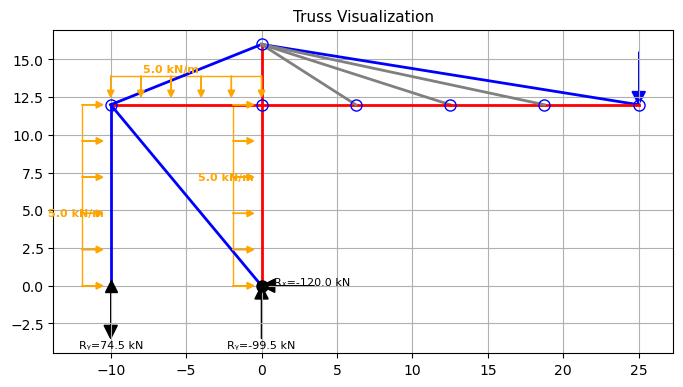

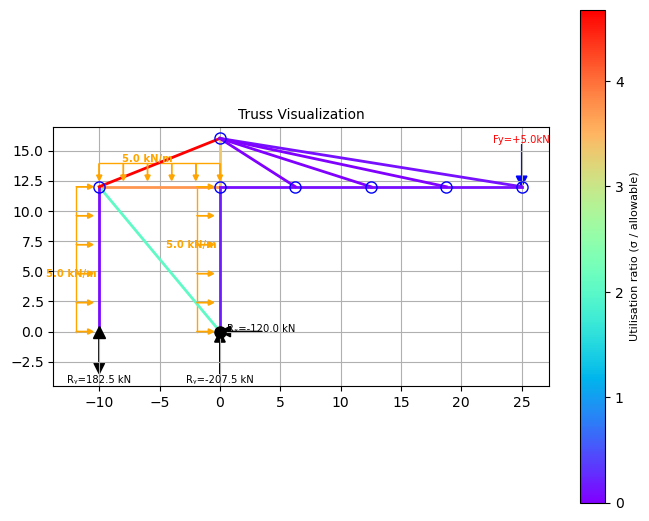

In [17]:
# STRUCTURAL RE-ANALYSIS
reactions2 = compute_support_reactions(nodes, members)
member_forces2 = solve_truss_joint_iteration(nodes, members)
member_moments2 = compute_member_bending_moments(members)

# Plot a figure of the new truss system
viz.visualize_truss(nodes, members, reactions=reactions2, plot_loads=True, forces=member_forces2, show_forces=True, moments=member_moments2, show_moment_labels=False)
viz.visualize_truss(nodes, members, textscale=0.9, reactions=reactions, plot_loads=True, show_load_labels=True, utilisations=utilisations, show_utilisations=True, show_colorbar=True )


## 13. Finally: Save your new structure back to a DXF to import into AutoCAD

In [16]:
from import_functions import export_to_dxf

OUTPUT_DXF = "scaled_structure.dxf"

# save new structure
export_to_dxf(nodes, members, OUTPUT_DXF)

=> DXF exported to scaled_structure.dxf
